In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [123]:
# status_filter='PNS'
status_filter='In-Progress'
# status_filter='Complete'

In [124]:
def get_unique_values_with_counts(dataframe, column_name):
    """
    This function returns a dictionary with unique values in a specified column of a dataframe
    and their corresponding counts.
    
    Parameters:
    dataframe (pd.DataFrame): The dataframe containing the data.
    column_name (str): The name of the column to extract unique values and counts from.
    
    Returns:
    dict: A dictionary where keys are unique values and values are their counts.
    """
    value_counts = dataframe[column_name].value_counts()
    return value_counts.to_dict()

def plot_unique_value_distribution(df, column_name):
    """
    Plots a bar chart of the unique values in the specified column of the DataFrame,
    with a label on each bar specifying the value's occurrence out of the total number
    of values in the column.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The column name to analyze.
    """
    value_counts = df[column_name].value_counts()
    total = len(df[column_name])

    plt.figure(figsize=(10, 6))
    bars = plt.bar(value_counts.index, value_counts.values, color='skyblue')

    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.title(f'Distribution of Unique Values in "{column_name}"')
    
    # Adding labels on each bar
    for bar in bars:
        height = bar.get_height()
        label = f'{height}/{total}'
        plt.text(bar.get_x() + bar.get_width() / 2, height, label, ha='center', va='bottom', size=6)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Function to find keywords in specified columns
def find_keywords(row, columns, keywords):
    found_keywords = []
    for column in columns:
        for keyword in keywords:
            if pd.notna(row[column]) and keyword in row[column]:
                found_keywords.append(keyword)
    return found_keywords

def plot_failure_rate_by_column(df, column, status_filter, threshold=None):
    """
    Plots the failure rate by a given column in the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column (str): The column to group by and plot the failure rate.
    status_filter (str): The project status to filter on. Used for the chart title.
    threshold (float): An optional threshold to filter the failure rate. Defaults to None.
    
    Returns:
    None
    """
    # Calculate the failure rate and the ratio of num_failed/total
    grouped = df.groupby(column).agg(
        num_failed=('failure', 'sum'),
        total=('failure', 'size')
    )
    grouped['failure_rate'] = grouped['num_failed'] / grouped['total']
    
    # If a threshold is provided, filter the failure rate
    if threshold is not None:
        grouped = grouped[grouped['failure_rate'] >= threshold]
    
    # Filter out entries with 0 failure rate
    grouped = grouped[grouped['failure_rate'] > 0]
    
    # Sort the failure rate
    grouped = grouped.sort_values(by='failure_rate', ascending=False)
    
    # Plot the failure rate
    plt.figure(figsize=(12, 8))
    bars = plt.bar(grouped.index, grouped['failure_rate'], color='skyblue')
    plt.title(f'Failure Rate by {column.replace("_", " ").title()} (where project status == "{status_filter}")')
    plt.xlabel(column.replace('_', ' ').title())
    plt.ylabel('Failure Rate')
    plt.xticks(rotation=45, ha='right')
    
    # Add text annotations on top of the bars
    for bar, num_failed, total in zip(bars, grouped['num_failed'], grouped['total']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{num_failed}/{total}', 
                 ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def plot_failure_rate_by_two_columns(df, column1, column2, status_filter, threshold=None):
    """
    Plots the failure rate by two given columns in the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column1 (str): The first column to group by and plot the failure rate.
    column2 (str): The second column to group by and plot the failure rate.
    status_filter (str): The project status to filter on. Used for the chart title.
    threshold (float): An optional threshold to filter the failure rate. Defaults to None.
    
    Returns:
    None
    """
    # Calculate the failure rate and the ratio of num_failed/total
    grouped = df.groupby([column1, column2]).agg(
        num_failed=('failure', 'sum'),
        total=('failure', 'size')
    )
    grouped['failure_rate'] = grouped['num_failed'] / grouped['total']

    # Filter out entries with 0 failure rate
    grouped = grouped[grouped['failure_rate'] > 0]
    # Filter out entries with more than 1 sample 
    grouped = grouped[grouped['total'] > 1]
    grouped = grouped.head(20)

    # print(grouped)
    
    # If a threshold is provided, filter the failure rate
    if threshold is not None:
        grouped = grouped[grouped['failure_rate'] >= threshold]
    
    # Sort the failure rate
    grouped = grouped.sort_values(by='failure_rate', ascending=False).reset_index()
    
    # Plotting
    plt.figure(figsize=(12, 6))
    bars = plt.bar(grouped.index, grouped['failure_rate'], color='skyblue')
    plt.xlabel(f'{column1} and {column2}')
    plt.ylabel('Failure Rate')
    plt.title(f'Failure Rate by {column1} and {column2} - Status: {status_filter}')
    plt.xticks(ticks=grouped.index, labels=grouped.apply(lambda x: f"{x[column1]} & {x[column2]}", axis=1), rotation=90)

    # Add text annotations on top of the bars
    for bar, num_failed, total in zip(bars, grouped['num_failed'], grouped['total']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{num_failed}/{total}', 
                 ha='center', va='bottom', size=6)
    
    plt.tight_layout()
    plt.show()

In [125]:
df = pd.read_csv("https://datasocibmproject.s3.ap-southeast-2.amazonaws.com/structured_data/capital_project_schedules_and_budgets_1.csv")
df = df.drop(df.columns[0], axis=1)

In [126]:
# get_unique_values_with_counts(df, 'project_school_name')

### Filter by project status - PNS, In-Progress or Complete

In [127]:
df = df[df['project_status_name'] == status_filter]
df = df.drop(columns=['project_status_name'])

In [128]:
print(f"Failure for project status '{status_filter}'")
get_unique_values_with_counts(df, 'failure')


Failure for project status 'In-Progress'


{False: 1569, True: 589}

In [129]:
# Checking for missing values in the dataset
missing_values = df.isnull().sum()
missing_values

df['project_phase_name'] = df['project_phase_name'].fillna('Unknown')

# Verify if the missing values have been handled
missing_values_after = df.isnull().sum()
missing_values_after

project_geographic_district                                      0
project_building_identifier                                      0
project_school_name                                              0
project_type                                                     0
project_description                                              0
project_phase_name                                               0
project_phase_actual_start_date                                  0
project_phase_planned_end_date                                   0
project_phase_actual_end_date                                 2158
project_budget_amount                                            0
final_estimate_of_actual_costs_through_end_of_phase_amount       4
total_phase_actual_spending_amount                               0
dsf_number_s                                                     0
failure                                                          0
dtype: int64

In [130]:
# from scipy.stats import chi2_contingency

# chi2_results = {}
# categorical_vars = ['project_type', 'project_phase_name'] 
# # categorical_vars = df.select_dtypes(include=[object]).columns

# for var in categorical_vars:
#     contingency_table = pd.crosstab(df[var], df['failure'])
#     chi2, p, dof, ex = chi2_contingency(contingency_table)

#     # print(f'Chi-square statistic: {chi2}')
#     # print(f'p-value: {p}')
#     # print(f'Degrees of freedom: {dof}')

#     # Interpretation
#     if p < 0.05:
#         print(f"There is a significant association between '{var} and 'failure'.")
#     else:
#         print(f"There is no significant association between '{var}' and 'failure'.")

#     chi2_results[var] = chi2

# chi2_df = pd.DataFrame.from_dict(chi2_results, orient='index', columns=['Chi-Square Statistic'])

# # Bar plot
# chi2_df.plot(kind='bar', legend=False)
# plt.ylabel('Chi-Square Statistic')
# plt.title('Chi-Square Statistics for Categorical Variables')
# plt.show()

In [131]:
# plot_unique_value_distribution(df, 'project_type')

In [132]:
# plot_unique_value_distribution(df, 'project_geographic_district')

In [133]:
# plot_failure_rate_by_two_columns(df, 'project_geographic_district', 'project_type', status_filter)

In [134]:
# plot_failure_rate_by_column(df, 'project_geographic_district', status_filter)

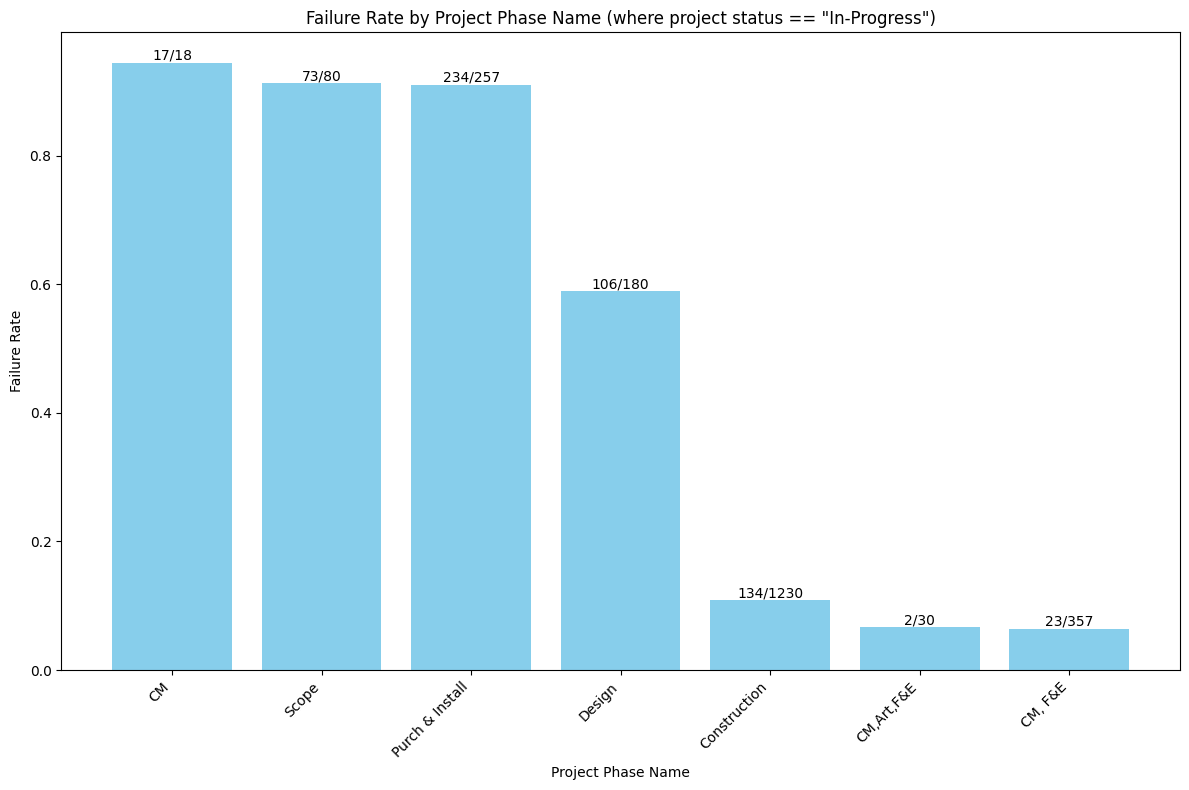

In [135]:
plot_failure_rate_by_column(df, 'project_phase_name', status_filter)

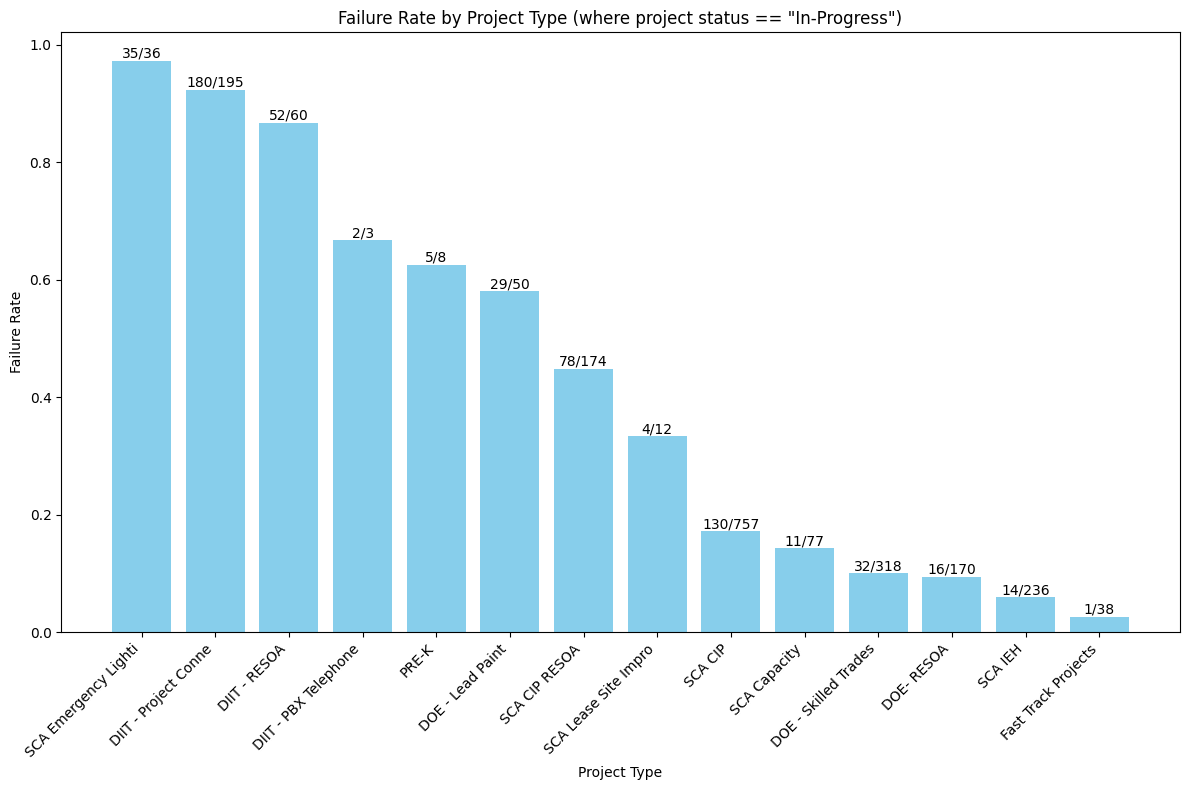

In [136]:
plot_failure_rate_by_column(df, 'project_type', status_filter)

### Splitting by project type

In [137]:
# List of keywords to keep
project_types = [
    "SCA", "CIP", "DIIT", "DOE", "DOES", "DOER",
    "RESOA", "IEH", "PRE-K", "DCAS", "FY", "FAST TRACK PROJECTS"
]

df_PNS = df.map(lambda x: x.replace('PREK', 'PRE-K') if isinstance(x, str) else x)

# Columns to check for project types
columns_to_check = ['project_type', 'project_phase_planned_end_date']

# Apply the function to each row
df['project_type_split'] = df.apply(lambda row: find_keywords(row, columns_to_check, project_types), axis=1)

# Explode the list into separate rows
df_exploded = df.explode('project_type_split')

# Filter out rows where 'project_type_split' is NaN
df_exploded = df_exploded[df_exploded['project_type_split'].notna()]

In [138]:
# Checking for duplicate rows
duplicate_rows = df_exploded.duplicated().sum()

# Removing duplicate rows if any
df_cleaned = df_exploded.drop_duplicates()

duplicate_rows, df_cleaned.shape

(775, (4169, 15))

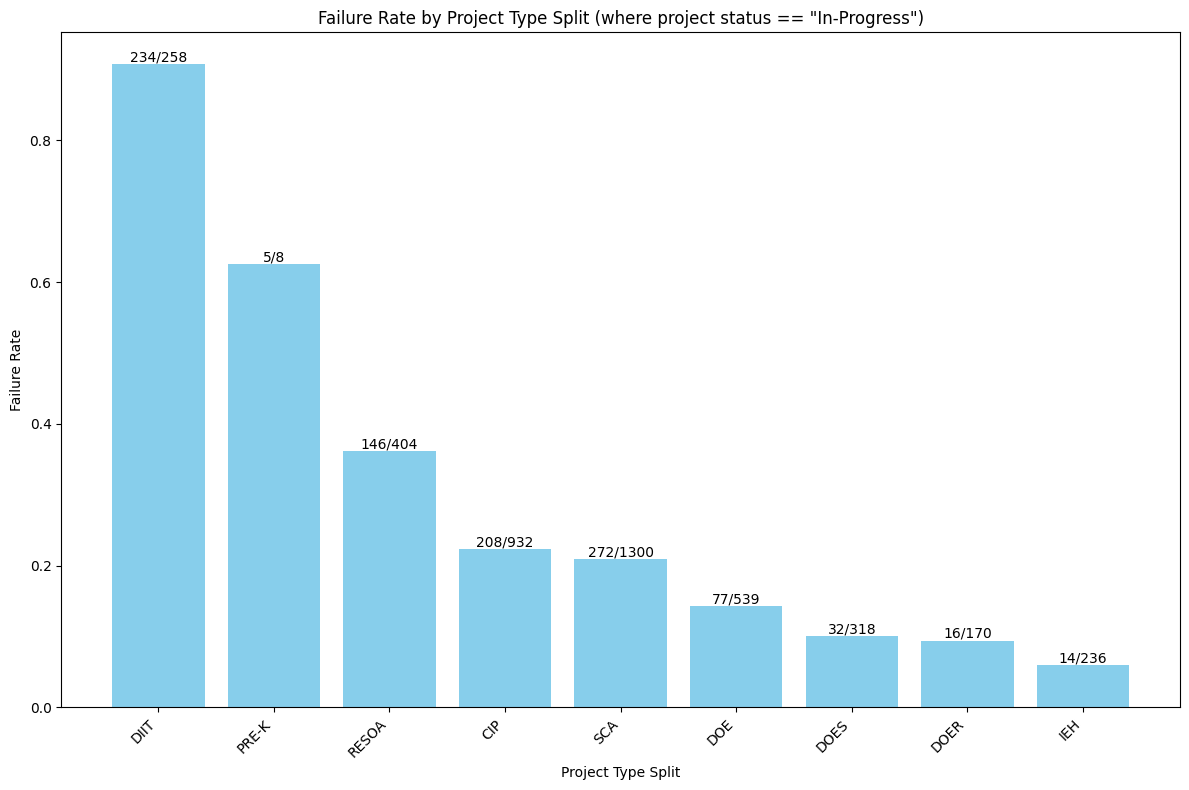

In [139]:
plot_failure_rate_by_column(df_cleaned, 'project_type_split', status_filter)